In [2]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Task 1

In [4]:
Activation = Callable[[torch.Tensor], torch.Tensor]
Loss = Callable[[torch.Tensor, torch.Tensor], torch.Tensor]
Optimizer = Callable[[torch.Tensor, torch.Tensor, torch.Tensor, float, float, Activation, Loss], tuple[torch.Tensor, float, float]]

In [7]:
def sigmoid(X: torch.Tensor) -> torch.Tensor:
    return (1 / (1 + torch.exp(-X))).clamp(1e-7, 1 - 1e-7)

def nll(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    return -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

In [9]:
def gradient_descent(
    X: torch.Tensor,
    y_true: torch.Tensor,
    W: torch.Tensor,
    b: float,
    learning_rate: float,
    activation: Activation,
    loss_fn: Loss
) -> tuple[torch.Tensor, float, float]:
    n_samples = X.shape[0]

    # Forward
    y_pred = activation(X @ W + b)

    # Loss
    loss = loss_fn(y_pred, y_true).mean().item()

    # Backward
    error = y_pred - y_true
    grad_W = X.T @ error / n_samples
    grad_b = error.mean()

    W -= learning_rate * grad_W
    b -= learning_rate * grad_b

    return W, b, loss


In [10]:
def train(
    X: torch.Tensor,
    y_true: torch.Tensor,
    W: torch.Tensor,
    b: float,
    learning_rate: float,
    epochs: int,
    activation: Activation,
    loss_fn: Loss,
    optimizer: Optimizer,
) -> tuple[torch.Tensor, float, list[float]]:
    W = W.detach().clone()

    loss_values = []
    for _ in range(epochs):
        W, b, loss = optimizer(X, y_true, W, b, learning_rate, activation, loss_fn)
        loss_values.append(round(loss, 4))

    return W, b, loss_values

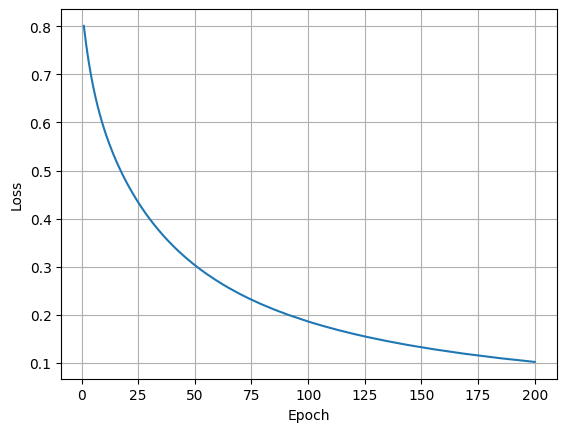

In [11]:
_, _, loss_gradient = train(
    X=torch.tensor([[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]]),
    y_true=torch.tensor([1, 0, 0]),
    W=torch.tensor([0.1, -0.2]),
    b=0,
    learning_rate=0.1,
    epochs=200,
    activation=sigmoid,
    loss_fn=nll,
    optimizer=gradient_descent
)

plt.plot(range(1, 201), loss_gradient)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [136]:
X_train = pd.read_csv("../datasets/songs-prediction-2025/train_x.csv", index_col=0).to_numpy()
y_train = pd.read_csv("../datasets/songs-prediction-2025/train_y.csv")["year"].astype(int)

In [137]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

In [138]:
y_train.describe()

count    14000.000000
mean      1998.366714
std         11.048088
min       1922.000000
25%       1994.000000
50%       2002.000000
75%       2006.000000
max       2011.000000
Name: year, dtype: float64

In [139]:
y_train = (y_train > 1998).astype(float)

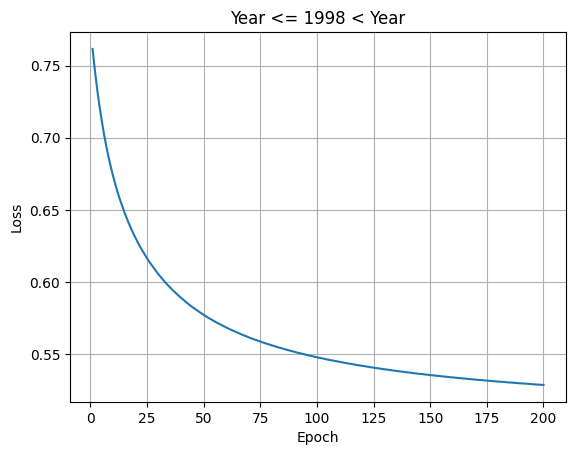

In [140]:
_, _, loss = train(
    X=torch.Tensor(X_train),
    y_true=torch.Tensor(y_train),
    W=torch.randn(X_train.shape[1]) / np.sqrt(X_train.shape[1]),
    b=0,
    learning_rate=0.1,
    epochs=200,
    activation=sigmoid,
    loss_fn=nll,
    optimizer=gradient_descent
)

plt.title("Year <= 1998 < Year")
plt.plot(range(1, 201), loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

# Task 2

In [34]:
class Node:
    def __init__(self, data: float, _children: tuple["Node", ...] = (), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Element(data={self.data}, grad={self.grad})"

    def __add__(self, other: "Node | float"):
        if not isinstance(other, Node):
            other = Node(other)

        result = Node(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += result.grad
            other.grad += result.grad

        result._backward = backward
        return result

    def __mul__(self, other: "Node | float"):
        if not isinstance(other, Node):
            other = Node(other)

        result = Node(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad

        result._backward = backward
        return result

    def relu(self):
        result = Node(max(0, self.data), (self,), "ReLU")

        def backward():
            if self.data > 0:
                self.grad += result.grad

        result._backward = backward
        return result

    def backward(self):
        nodes: list[Node] = []

        visited: set[Node] = set()
        def walk(node: Node):
            if node in visited:
                return

            visited.add(node)
            for parent in node._prev:
                walk(parent)
            nodes.append(node)

        walk(self)

        for node in nodes:
            node.grad = 0

        self.grad = 1

        for node in reversed(nodes):
            node._backward()

In [53]:
import unittest

unittest.main(argv=[''], exit=False)

class TestNode(unittest.TestCase):
    def test_add(self):
        a = Node(1)
        b = Node(2)
        c = a + b
        self.assertAlmostEqual(c.data, 3)

    def test_mult(self):
        a = Node(3)
        b = Node(4)
        c = a * b
        self.assertAlmostEqual(c.data, 12)

    def test_relu(self):
        a = Node(5).relu()
        b = Node(-5).relu()
        self.assertAlmostEqual(a.data, 5)
        self.assertAlmostEqual(b.data, 0)

    def test_add_backward(self):
        a = Node(2)
        b = Node(3)
        c = a + b
        c.backward()
        self.assertAlmostEqual(c.grad, 1)
        self.assertAlmostEqual(a.grad, 1)
        self.assertAlmostEqual(b.grad, 1)

    def test_mult_backward(self):
        a = Node(2)
        b = Node(-5)
        c = a * b
        c.backward()
        self.assertAlmostEqual(c.grad, 1)
        self.assertAlmostEqual(a.grad, -5)
        self.assertAlmostEqual(b.grad, 2)



.....
----------------------------------------------------------------------
Ran 5 tests in 0.002s

OK


# Task 3

## Adam

First moment: $ m_t = \beta_1 m_{t-1} + (1 - \beta_1) \frac{\partial L}{\partial w_t} $

Second moment: $ v_t = \beta_2 v_{t-1} + (1 - \beta_2) (\frac{\partial L}{\partial w_t})^2 $

Bias correction: $ \hat{m} = \frac{m_t}{1 - \beta_1^t} $, $ \hat{v_t} = \frac{v_t}{1 - \beta_2^t} $

Weight update: $ w_{t+1} = w_t - LR \frac{\hat{m_t}}{\sqrt{\hat{v_t} + \epsilon}} $

In [18]:
def train_adam(
    X: torch.Tensor,
    y_true: torch.Tensor,
    W: torch.Tensor,
    b: float,
    learning_rate: float,
    epochs: int,
    activation: Activation,
    loss_fn: Loss,
    beta1: float = 0.9,
    beta2: float = 0.999
):
    W = W.detach().clone()

    m_W = torch.zeros_like(W)
    m_b = 0

    v_W = torch.zeros_like(W)
    v_b = 0

    loss_values = []

    for epoch in range(1, epochs + 1):
        n_samples = X.shape[0]

        # Forward
        y_pred = activation(X @ W + b)

        # Loss
        loss = loss_fn(y_pred, y_true).mean().item()

        # Backward
        error = y_pred - y_true
        grad_W = X.T @ error / n_samples
        grad_b = error.mean()

        # First moment
        m_W = beta1 * m_W + (1 - beta1) * grad_W
        m_b = beta1 * m_b + (1 - beta1) * grad_b

        # Second moment
        v_W = beta2 * v_W + (1 - beta2) * (grad_W ** 2)
        v_b = beta2 * v_b + (1 - beta2) * (grad_b ** 2)

        # Bias correction
        m_W_hat = m_W / (1 - beta1 ** epoch)
        m_b_hat = m_b / (1 - beta1 ** epoch)

        v_W_hat = v_W / (1 - beta2 ** epoch)
        v_b_hat = v_b / (1 - beta2 ** epoch)

        # Weight update
        W -= learning_rate * m_W_hat / (torch.sqrt(v_W_hat) + 1e-7)
        b -= learning_rate * m_b_hat / (torch.sqrt(v_b_hat) + 1e-7)

        loss_values.append(round(loss, 4))

    return W, b, loss_values

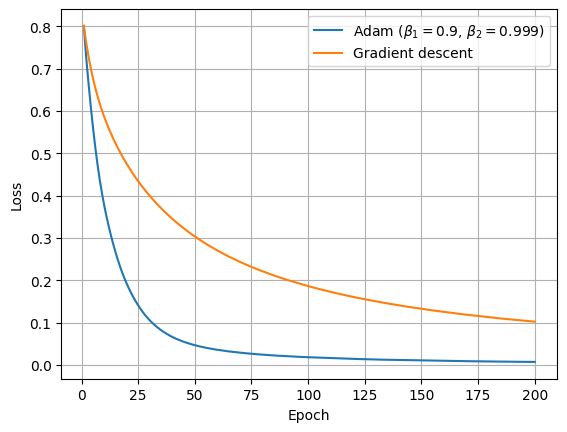

In [23]:
_, _, loss_adam = train_adam(
    X=torch.tensor([[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]]),
    y_true=torch.tensor([1, 0, 0]),
    W=torch.tensor([0.1, -0.2]),
    b=0,
    learning_rate=0.1,
    epochs=200,
    activation=sigmoid,
    loss_fn=nll,
)

plt.plot(range(1, 201), loss_adam, label=r"Adam ($\beta_1 = 0.9$, $\beta_2 = 0.999$)")
plt.plot(range(1, 201), loss_gradient, label="Gradient descent")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()